In [1]:
# OS 접근을 위한 시스템 라이브러리
import os
# 전역변수 사용을 위한 시스템 라이브러리
import glob
# 시간 데이터 사용을 위한 시스템 라이브러리
import time

# 이미지 시각화를 위한 라이브러리
import PIL
import imageio
# 연산을 위한 라이브러리
import numpy as np
# 텐서 관리를 위한 라이브러리
import tensorflow as tf
# 모델 설계를 위한 라이브러리
from tensorflow.keras import layers

# 데이터 시각화를 위한 라이브러리
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# 텐서플로우 버전 학인
print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
# 패션 mnist 데이터셋 불러오기
fashion_mnist = tf.keras.datasets.fashion_mnist

# y_train, y_test 부분은 언더스코어 처리
(train_x, _), (test_x, _) = fashion_mnist.load_data()

기존의 mnist 데이터셋을 활용하는 이미지 분류 문제가 아니기 때문에 별도의 정답 레이블이 필요하지 않다.  
그렇기에 y_train과 y_test부분을 언더스코어 처리하여 레이블을 부시하도록 한다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


이미지의 각 픽셀은 0~255까지의 데이터로 이루어져 있다.  
각 픽셀이 -1과 1사이의 값을 가지도록 정규화를 진행한다.

In [4]:
# 중간 값을 0으로 맞추기 위해 각 픽셀에 127.5를 뺀 다음, 127.5로 나눠 정규화 진행
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
# 학습 데이터의 형상 확인
train_x.shape

(60000, 28, 28)

28X28 크기를 가진 6만장의 학습 이미지 데이터가 존재하는 것을 확인할 수 있다.  
CNN 계층을 다루기 위해 채널 수를 알 수 있는 차원을 추가하도록 한다.

In [6]:
# 학습 데이터에 채널 수(흑백:1) 차원 추가 후, 실수형으로 캐스팅
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')

train_x.shape

(60000, 28, 28, 1)

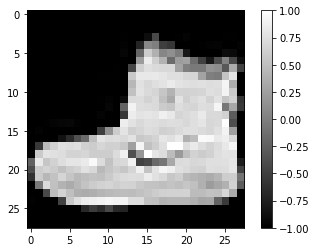

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

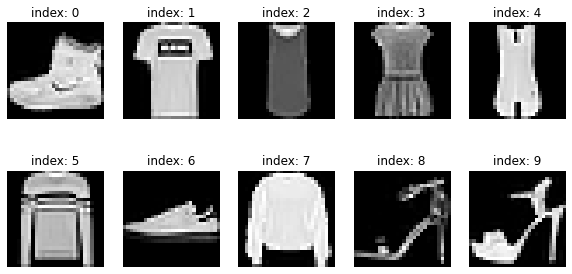

In [8]:
# 전체 프레임의 크기 설정
plt.figure(figsize=(10, 5))

# 0~9까지 반복
for i in range(10):
    # 2행 5열의 인덱스 생성
    plt.subplot(2, 5, i+1)
    # 이미지 데이터를 28X28크기의 grayscale로 출력
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    # 각 이미지의 제목 지정
    plt.title(f'index: {i}')
    # 축 정보 제거
    plt.axis('off')
plt.show()

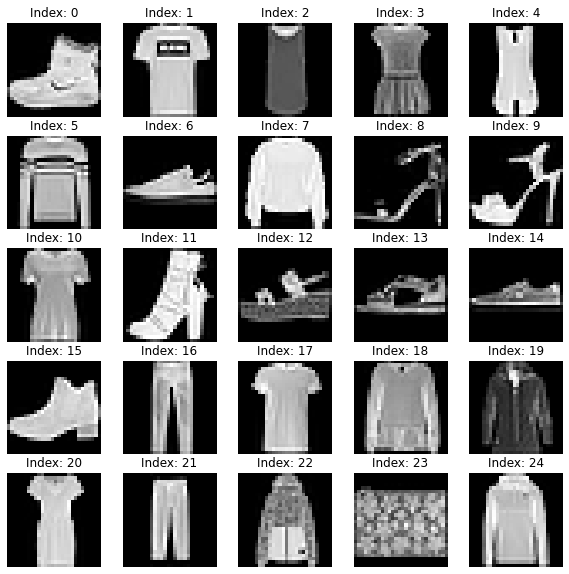

In [9]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_x[i].reshape(28,28), cmap='gray')
    plt.title(f'Index: {i}')
    plt.axis('off')
    
plt.show()

In [10]:
# 전체 데이터를 섞기 위한 버퍼 설정
BUFFER_SIZE = 60000
# 배치 크기 설정
BATCH_SIZE = 256

In [11]:
# 전체 데이터를 섞고, 지정된 범위로 미니 배치 생성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
def make_generator_model():
    # Sequential 모델 객체 생성
    model = tf.keras.Sequential()
    
    # Dense 레이어 추가
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 레이어 추가
    model.add(layers.BatchNormalization())
    # 횔성화 함수 레이어 추가
    model.add(layers.LeakyReLU())
    
    # 형상 변경
    model.add(layers.Reshape((7, 7, 256)))
    # output 텐서 형상 확인
    assert model.output_shape == (None, 7, 7, 256)
    
    #Convolution 업샘플링 레이어 추가
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # output 텐서 형상 확인
    assert model.output_shape == (None, 7, 7, 128)
    # 배치 정규화 레이어 추가
    model.add(layers.BatchNormalization())
    # 활성화 함수 레이어 추가
    model.add(layers.LeakyReLU())
    
    # Convolution 업샘플링 레이어 추가
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # output 텐서 형상 확인
    assert model.output_shape == (None, 14, 14, 64)
    # 배치 정규화 레이어 추가
    model.add(layers.BatchNormalization())
    # 활성화 함수 레이어 추가
    model.add(layers.LeakyReLU())
    
    # 결과 출력 Convolution 업샘플링 레이어 추가
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

Conv2DTranspose 레이어는 일반적인 Convolution 레이어와는 반대로 이미지 사이즈를 넓여주는 업샘플링 작업을 진행한다.  
위의 모델에서는 3번의 Conv2DTranspose 레이어를 통해 이미지의 크기를 `(7, 7, 256) -> (14, 14, 64) -> (28, 28, 1)`의 형태로 키워나간다.  
레이어의 사이사이에는 가중치가 폭발하지 않도록 배치 정규화 레이어를 추가하여 가중치 값을 전규화 시킨다.  
또한 중간층과는 다르게 마지막 층의 활성화 함수로 `tanh`를 사용하는 이유는 픽셀값을 -1~1사이로 정규화시켰던 데이터셋과 같이 출력 값을 동일하게 하기 위함이다.

In [17]:
# 생성자 모델 생성
generator = make_generator_model()
# 모델 구조 확인
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)        

In [18]:
# 1부터 100까지의 난수 생성
noise = tf.random.normal([1,100])

In [19]:
# 노이즈 데이터를 모델에 입력
generated_image = generator(noise, training=False)
# 출력 결과 확인
generated_image.shape

TensorShape([1, 28, 28, 1])

아직 모델을 학습시키기 전이라서 의미 있는 결과가 출력되지는 않겠지만, 텐서플로우 2.0 이후 버전부터는 레이어와 모델에 call 메서드를 구현해 놓았기 때문에 생성자 모델에 입력 값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성되게 된다.  
단, 지금은 학습을 시키는 과정이 아니므로 BatchNormalization의 훈련시기와 추론시기의 행동 차이를 고려해서 `training=False`로 설정하도록 한다.

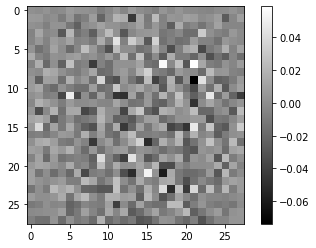

In [20]:
# 0번째와 3번째 축의 값을 0으로 변환하여 시각화
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

`matplotlib`는 2차원의 벡터만 시각화하여 보여줄 수 있는 라이브러리이므로 모델의 출력 데이터의 형상을 (28,28)로 맞춰준다.

In [21]:
def make_discriminator_model():
    # Sequential 모델 객체 생성
    model = tf.keras.Sequential()
    
    # Convolution 레이어 추가
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    # 활성화 함수로 LeakyReLU 사용
    model.add(layers.LeakyReLU())
    # 드롭아웃으로 전체 뉴런의 70%만 학습에 참여
    model.add(layers.Dropout(0.3))
    
    # Convolution 레이어 추가
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    # 활성화 함수로 LeakyReLU 사용
    model.add(layers.LeakyReLU())
    # 드롭아웃으로 전체 뉴런의 70%만 학습에 참여
    model.add(layers.Dropout(0.3))
    
    # 플래튼 레이어 추가
    model.add(layers.Flatten())
    # 덴스 레이어 추가
    model.add(layers.Dense(1))
    
    return model

판별자는 생성자와는 다르게 이미지의 크기를 줄여나가며 학습을 진행하여 이미지의 크기가 `(28, 28, 1) -> (14, 14, 64) -> (7, 7, 128)`로 축소하게 된다.  
마지막에는 `Flatten`레이어를 통해 3차원 이미지를 1차원 벡터로 전개를 하면서 7X7X128 = 6272, 즉 (1, 6272)형상의 벡터로 변환이 된다.

In [22]:
# 판별자 모델 생성
discriminator = make_discriminator_model()
# 판별자 모델 구조 확인
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [23]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00320537]], dtype=float32)>

위에서 제작한 아무 의미 없는 데이터를 넣었더니 아무 의미 없는 텐서가 출력되었다.

딥러닝 모델이 학습을 하기 위해서는 손실함수와 최적화함수가 필요하다.  
여기서 GAN은 손실함수로 교차 엔트로피를 사용하는데 그 이유는 판별자가 한 개의 이미지가 진짜인지 가짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하기 때문이다.  
Real Image에 대한 레이블을 1, Fake Image에 대한 레이블을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같다.  
* 생성자: 판별자가 Fake Image에 대해 판별한 값, 즉 `D(fake_image)`값이 1에 가까워 지는 것
* 판별자: Real Image 판별값, 즉 `D(real_image)`값이 1에, Fake Image 판별값, 즉 `D(fake_image)`값이 0에 가까워지는 것

위에서 설계한 판별자 모델엔 sigmoid나 tanh과 같은 값을 정규화시키는 활성화 함수가 없어 출력값은 범위가 지정되지 않은 실수값들이다. 하지만 tf.keras.losses에서 제공하는 교차 엔트로피 함수는 본인에게 들어오는 input 값의 범위가 0-1 사이에 분포하는 확률값이라고 가정을 하기 때문에 `from_logits`를 `True`로 설정을 해주어야 `BinaryCrossEntropy`에 입력된 값을 함수 내부에서 sigmoid함수를 사용해 0-1 사이의 값으로 정규화한 후, 올바르게 계산을 하게 된다.

In [24]:
# 손실함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
# 생성자 손실 함수 정의
def generator_loss(fake_output):
    # 비교 대상을 fake_output과 크기가 같고 1로 채워진 텐서로 지정
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
# 판별자 손실 함수 정의
def discriminator_loss(real_output, fake_output):
    # 비교 대상을 real_output과 크기가 같고 1로 채워진 텐서로 지정
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 비교 대상을 fake_output과 크기가 같고 0으로 채워진 텐서로 지정
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # 두 loss의 합
    total_loss = real_loss + fake_loss
    
    return total_loss

손실 함수도 중요하지만, 판별자가 real_output과 fake_output을 얼마나 정확히 판별하는지의 accuracy를 계산해보는 것도 GAN의 학습에서는 매우 중요하다. 특히 두 결과의 accuracy를 따로 계산해서 비교하는 작업이 매우 유용하다.  
이 때, 판별자가 real_output과 fake_output의 accuracy를 1.0에 가까울 정도로 정확하게 판별해 내는 것은 모델의 성능이 좋은 것이 아니라 생성자가 만들어낸 fake_output이 real_output과 차이가 많이 나기 때문에 판별자가 너무 쉽게 잡아낸다는 것을 의미한다. 그래서 real accuracy와 fake accuracy는 초반에 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 가깝다면 아직은 생성자가 판별자를 잘 속이지 못하고 있다는 것을 의미한다.

In [27]:
def discriminator_accuracy(real_output, fake_output):
    # real_output의 값이 0.5 이상인지의 여부를 나타내는 0과 1의 불리언 값으로 정확도 계산
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    # fake_output의 값이 0.5 미만인지의 여부를 나타내는 0과 1의 불리언 값으로 정확도 계산
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    
    return real_accuracy, fake_accuracy

`real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])` 라면, 연산 순서는 다음과 같다.
* (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
    * `>>> tf.Tensor([False, False, True, True])`
* (2) tf.cast((1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    * `>>> tf.Tensor([0.0, 0.0, 1.0, 1.0])`
* (3) tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    * `>>> 0.5`

손실 함수와 정확도 계산 함수를 정의한 다음은 최적화 함수를 정의할 차례이다. 최적화 함수는 Adam 최적화 기법을 사용한다.  
여기에서 유의해야할 점은 생성자와 판별자는 별개의 네트워크이기 때문에 optimizer를 따로 정의해야 한다는 것이다.

In [29]:
# 생성자 옵티마이저를 Adam으로 정의하고 학습률을 매우 작은 값으로 지정
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# 판별자 옵티마이저를 Adam으로 정의하고 학습률을 매우 작은 값으로 지정
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

학습 진행을 확인하기 위해서 생성자가 생성한 샘플을 확인할 것인데, 여기에서 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로 고정된 seed 노이즈를 만들어두도록 한다.  
샘플은 한 번에 16개씩 만들 것이고, 그렇게 되면 100차원의 노이즈를 16개, 즉 `(16, 100)`형상의 벡터를 만드는 것이다.

In [30]:
# 샘플 차원 수 지정
noise_dim = 100
# 한 번에 만들 샘플 수 지정
num_examples_to_generate = 16

# 지정된 값으로 무작위값을 가진 노이즈 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])
# 생성된 노이즈 형상 확인
seed.shape

TensorShape([16, 100])

In [42]:
# 데코레이터 함수 지정
@tf.function
def train_step(images):
    # 생성자 입력 노이즈
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 생성자와 판별자의 기울기를 기록할 수 있는 테이프 오픈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 생성자로 입력 노이즈를 활용하여 fake image 생성
        generated_images = generator(noise, training=True)
        
        # real image를 판별자에 입력하여 그 결과 저장
        real_output = discriminator(images, training=True)
        # fake image를 판별자에 입력하여 그 결과 저장
        fake_output = discriminator(generated_images, training=True)
        
        # fake image에 대한 생성자 손실함수 값 저장
        gen_loss = generator_loss(fake_output)
        # real/fake image에 대한 판별자 손실함수 값 저장
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # real/fake image에 대한 판별자의 정확도 저장
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # 생성자의 기울기 변화 기록
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # 판별자의 기울기 변화 기록
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 생성자의 기울기에 대한 최적화 작업 진행
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # 판별자의 기울기에 대한 최적화 작업 진행
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 생성자의 손실함수 값, 판별자의 손실함수 값, 실제 이미지의 정확도, 가짜 이미지의 정확도 리턴
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

* (1) 입력 데이터: Real Image 역할을 할 `images` 한 세트를 입력으로 받음
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 `noise`를 `images` 한 세트와 같은 크기인 `BATCH_SIZE` 만큼 생성함
* (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기
* (4) generated_images 생성 : generator가 `noise`를 입력받은 후 `generated_images` 생성
* (5) discriminator 판별 : discriminator가 Real Image인 `images`와 Fake Image인 `generated_images`를 각각 입력받은 후 `real_output`, `fake_output` 출력
* (6) loss 계산 : `fake_output`, `real_output`으로 generator와 discriminator 각각의 loss 계산
* (7) accuracy 계산 : `fake_output`, `real_output`으로 discriminator의 정확도 계산
* (8) gradient 계산 : `gen_tape`와 `disc_tape`를 활용해 gradient를 자동으로 계산
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [32]:
# 학습 현황을 볼 수 있는 샘플을 생성하는 함수 정의
def generate_and_save_images(model, epoch, it, sample_seeds):
    # 고정된 seed에 대한 결과 저장
    predictions = model(sample_seeds, training=False)
    
    # 4X4 크기의 프레임 정의
    fig = plt.figure(figsize=(4,4))
    
    # predictions의 크기만큼 반복
    for i in range(predictions.shape[0]):
        # 4행 4열의 인덱스 별 서브 프레임 생성
        plt.subplot(4, 4, i+1)
        # 그래프 그리기
        plt.imshow(predictions[1, :, :, 0], cmap='gray')
        # 축 정보 비노출
        plt.axis('off')
        
    # 생성된 프레임을 해당 경로에 png파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    
    # 프레임 보이기
    plt.show()

이제 `train_step()`함수가 리턴하는 `gen_loss`,`disc_loss`,`real_accuracy`,`fake_accuracy`의 값을 저장하고 있는 딕셔너리를 만들고 매 epoch마다 시각화하는 함수를 만들어 그 흐름을 파악해본다.

In [33]:
from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기를 15,6으로 지정
rcParams['figure.figsize'] = 15, 6

# 히스토리를 시각화하는 함수 정의
def draw_train_history(history, epoch):
    # 손실함수 값에 대한 기록 요약
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # 정확도 값에 대한 기록 요약
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

모델이 복잡해지고 오래 걸릴수록 모델에 대한 저장 및 버전 관리는 필수적이다. checkpoint에 optimizer와 생성자, 판별자가 학습한 모델 가중치를 저장하도록 한다.

In [34]:
# 모델 저장 경로 지정
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

# 모델 저장 디렉터리 지정
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# 각 모델의 옵티마이저와 가중치 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [38]:
# 모델 학습 함수 정의
def train(dataset, epochs, save_every):
    # 학습 시작 시간
    start = time.time()
    # 히스토리 딕셔너리 초기화
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    # 설정한 에폭만큼 학습 반복
    for epoch in range(epochs):
        # 각 에폭 시작 시간
        epoch_start = time.time()
        # 데이터셋의 크기만큼 반복
        for it, image_batch in enumerate(dataset):
            # 생성자 손실함수 값, 판별자 손실함수 값, 실제 이미지 정확도, 가짜 이미지 정확도 반환
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            
            # 각각의 변수에 든 값을 히스토리 딕셔너리에 리스트로 저장
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            # 배치 인덱스가 50의 배수가 될 때마다
            if it % 50 == 0:
                # 화면 초기화
                display.clear_output(wait=True)
                # 고정된 seed를 통해 생성된 이미지 저장
                generate_and_save_images(generator, epoch+1, it+1, seed)
                # 에폭과 배치 순서 출력
                print('Epoch {} | iter {}'.format(epoch+1,it+1))
                # 에폭에 소요된 시간 출력
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        # 모델 저장 간격
        if (epoch + 1) % save_every == 0:
            # 모델 저장
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        # 화면 초기화
        display.clear_output(wait=True)
        # 고정된 seed를 통해 생성된 이미지 저장
        generate_and_save_images(generator, epochs, it, seed)
        # 학습에 소요된 시간 출력
        print('Time for trainig : {} sec'.format(int(time.time()-start)))
        
        # 에폭 별 학습 결과 추이 그래프 그리기
        draw_train_history(history, epoch)

In [36]:
# 에폭 진행 5회마다 모델 저장
save_every = 5
# 에폭 50회 반복
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

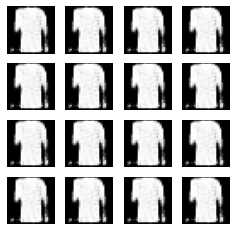

Time for trainig : 1192 sec


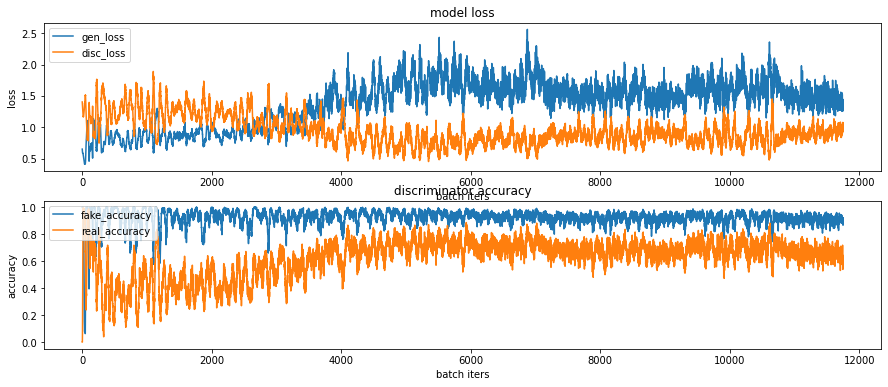

CPU times: user 8min 17s, sys: 1min 14s, total: 9min 32s
Wall time: 19min 54s


In [43]:
%%time
# 학습 시작
train(train_dataset, EPOCHS, save_every)

In [44]:
# GIF 파일 저장 경로 지정
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

# 'I' 모드는 이미지를 인덱스 기반의 이미지로 저장하는 모드
# with 문을 사용하여 writer를 자동으로 닫음
with imageio.get_writer(anim_file, mode='I') as writer:
    # 저장될 파일명 경로지정
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    # 저장된 파일명들을 리스트에 저장
    filenames = sorted(filenames)
    last = -1
    # 찾은 파일명을 순차적으로 인덱스와 함께 반복
    for i, filename in enumerate(filenames):
        # 이미지를 추출할 프레임을 지정하여 계산
        frame = 2*(i**0.5)
        # 각 값을 반올림하여 이미지를 추출할 프레임인지 판단
        if round(frame) > round(last):
            last = frame
        else:
            continue
        # 이미지 파일 읽기
        image = imageio.imread(filename)
        # 읽어온 이미지 파일을 GIF에 추가
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# 애니메이션 파일 확인
!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1065166 Jan 22 09:13 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


위에서 설정한 경로에 가면 모델의 학습 결과를 GIF 형식으로 확인할 수 있다.